## Objective

You work at Mastercard and have all information about transactions that users make with their credit card.

Your boss wants to implement the following products and needs your help.

Your boss wants to identify those users that in the your data set never went above the monthly credit card limit. The goal of this is to automatically increase their limit. Can you send him the list of IDs?

On the other hand, he wants to implement an algorithm that as soon as a user goes above her monthly limit, it triggers an alert so that the user can be notified about that. Build a function that for each day, returns a list of users who went above their credit card monthly limit on that day.

Finally, your boss is very concerned about frauds cause they are a huge cost for credit card companies. He wants to implement an unsupervised algorithm for the reasons we discussed above.
Build a model that returns all transactions that seem unusual and are worth being investigated further.

## Datasets

The 2 tables are:

cc_info - general information about the credit card and its holder

Columns:

* credit_card : credit card number. Can be joined to credit_card in the other table
* city : where the credit card holder lives
* state : in which state the credit card holder lives
* zipcode : credit card holder zipcode
* credit_card_limit : this is the credit card monthly limit. Credit card holders should be careful in not going above this limit in total money spent per month. The credit card limit is by calendar month

transactions - information about each transaction that happens between Aug, 1 and Oct, 30 for the credit cards in cc_info.

Columns:

* credit_card : credit card number. Can be joined to credit_card in the other table
* date : when the transaction happened (GMT time)
* transaction_dollar_amount : transaction amount in dollars
* long : longitude of where the transaction happened
* lat : latitude of where the transaction happened


In [1]:
import pandas
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})  
pandas.set_option('display.max_columns', 10)
pandas.set_option('display.width', 350)
  
card = pandas.read_csv("https://drive.google.com/uc?export=download&id=15KcmXlHb3pCgcApSCkzr_dXnqwy_K9rm")
print(card.head())

        credit_card      city state  zipcode  credit_card_limit
0  1280981422329509    Dallas    PA    18612               6000
1  9737219864179988   Houston    PA    15342              16000
2  4749889059323202    Auburn    MA     1501              14000
3  9591503562024072   Orlando    WV    26412              18000
4  2095640259001271  New York    NY    10001              20000


In [2]:
transaction = pandas.read_csv("https://drive.google.com/uc?export=download&id=1yYIfmlHPWvlxiGWumhzAKY97kAQAGDJk", parse_dates=['date'])
print(transaction.head())

        credit_card                date  transaction_dollar_amount       Long        Lat
0  1003715054175576 2015-09-11 00:32:40                      43.78 -80.174132  40.267370
1  1003715054175576 2015-10-24 22:23:08                     103.15 -80.194240  40.180114
2  1003715054175576 2015-10-26 18:19:36                      48.55 -80.211033  40.313004
3  1003715054175576 2015-10-22 19:41:10                     136.18 -80.174138  40.290895
4  1003715054175576 2015-10-26 20:08:22                      71.82 -80.238720  40.166719


#### Merge the datasets on credit card

In [3]:
data=pandas.merge(transaction, card, how='left')
  
# check no data explosion because of a many-to-many join
print(len(data)==len(transaction))

True


In [4]:
print(data.describe())

        credit_card  transaction_dollar_amount           Long            Lat        zipcode  credit_card_limit
count  2.945880e+05              294588.000000  294588.000000  294588.000000  294588.000000      294588.000000
mean   5.424562e+15                  86.008036     -76.235238      40.937669   18073.772516       15502.053716
std    2.555803e+15                 124.655954      20.135015       5.391695   23945.510551        7956.291556
min    1.003715e+15                   0.010000    -179.392887     -68.046553     690.000000        2000.000000
25%    3.344214e+15                  29.970000     -80.209708      40.487726    3280.000000       10000.000000
50%    5.353426e+15                  58.470000     -73.199737      42.403066    5820.000000       15000.000000
75%    7.646245e+15                 100.400000     -72.091933      43.180015   18612.000000       20000.000000
max    9.999757e+15                 999.970000     179.917513      78.914330   98401.000000       55000.000000


## Q: Identify users that never went above the monthly credit card limit

We will check how much each user has spent in total per calendar month and then compare to their monthly limit. This way we will identify users who went above the limit at least once. Finally we will pick all users not in this list.

#### Extract month from date

In [5]:
data['month']=data['date'].dt.month

#### Find total spent per month per user

In [6]:
users_above_limit = data.groupby(['credit_card', 'month']).apply(
                    lambda x: pandas.Series({
                             # credit card limit
                            'credit_card_limit': x['credit_card_limit'].max(),
                             # total spent per month
                            'total_spent': x['transaction_dollar_amount'].sum()})
).reset_index()

#### Unique users who went above the limit at least once

In [7]:
users_above_limit = users_above_limit.query('total_spent>credit_card_limit')['credit_card'].unique()
print(len(users_above_limit))

122


#### Users who are not in users_above_limit

In [8]:
users_no_limit = card['credit_card'][~card['credit_card'].isin(users_above_limit)]
print(users_no_limit.head())

2    4749889059323202
3    9591503562024072
4    2095640259001271
5    1997929794676601
6    5449610971108305
Name: credit_card, dtype: int64


In [9]:
print(len(users_no_limit), "users never went above the limit")

862 users never went above the limit


## Q: Build a function that, for each day, returns a list of users who went above their credit card monthly limit on that day

We assume here that at the beginning of the new month, user total money spent gets reset to zero.

In [10]:
def alert_function (data_input, day_input, month_input, year_input):
   # extract day from timestamp
   # add alert day to the dataset
   # subset dataset keeping only prior transactions in the same month
   data_input['date_truncated'] = data_input['date'].dt.date
   data_input['date_alerts'] = datetime.datetime(year_input, month_input, day_input)
   tmp = data_input.query('date_truncated<=date_alerts.dt.date & month==date_alerts.dt.month').sort_values('date')
     
   # get cumsum of transaction amount by user
   # get previous day value of cumsum
   # keep only rows when previous value was below the limit and current one is above, and date is the alert date
   tmp['total_spent'] = tmp.groupby('credit_card')['transaction_dollar_amount'].cumsum()
   tmp['total_spent_previous_value'] = tmp.groupby('credit_card')['total_spent'].shift(1)
   tmp = tmp.query('total_spent>=credit_card_limit & total_spent_previous_value<credit_card_limit')
   tmp = tmp.query('date_truncated==date_alerts.dt.date') 
     
   return(tmp[['credit_card', 'total_spent', 'total_spent_previous_value', 'credit_card_limit', 'date_alerts']])               
  
print(alert_function(data, 16, 8, 2015))

             credit_card  total_spent  total_spent_previous_value  credit_card_limit date_alerts
230955  7850942767136368      4061.39                     3996.38               4000  2015-08-16
58222   2850146878241916      4005.39                     3988.08               4000  2015-08-16


## Q: Build a model that returns all transactions that seem unusual and are worth investigating further

We will take the following approach:


Feature engineering. We will create the following new variables:

Geographical distance between transaction location and user home
Geographical distance between consecutive transactions
Time difference between consecutive transactions

Our model will use the variables above + transaction_amount. We will normalize all variables by user. That way we will identify anomalies based on a given user typical behaviour


We will cluster transactions, look into the cluster characteristics, and identify the “anomaly clusters”. All transactions falling into one of those clusters will be labeled as anomaly

In [11]:
!pip3 install geocoder
!pip3 install geopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Feature Engineering
  
To get distance from user home, we need to get latitude/longitude of cities. I used Bing API here, because it's easier and faster to get an API key than Google get unique queries for which we need lat/long

In [12]:
import geocoder
import geopy.distance

data['api_string'] = data['city'] + ',' + data['state'] + ',' + data['zipcode'].map(str)
string = data['api_string'].unique()
  
print("We will need to call the API", len(string), "times")

We will need to call the API 124 times


In [13]:
city_api = pandas.DataFrame({'string': string,
                            'city_long' : np.nan,
                            'city_lat'  : np.nan})
i = 0
while i<len(city_api):
    geocode_add = geocoder.bing(city_api['string'][i], key='AvXRG3zc-wL5OC8Ceit7Jpx9m8hTwsS-iwFM9PoZiIVhjlobIfkuD6JO4s-n4ebG').latlng
    city_api.at[i, 'city_lat']  = geocode_add[0]
    city_api.at[i, 'city_long'] = geocode_add[1]
    i+=1

  
print(city_api.head())

               string   city_long   city_lat
0    Houston,PA,15342  -80.219017  40.242249
1  Washington,NH,3280  -72.096626  43.176285
2   Charlotte,VT,5445  -73.253204  44.310612
3     Dallas,PA,18612  -75.967857  41.351788
4    Seattle,WA,98060 -122.330276  47.603230


#### Merge to the main dataset via string

In [14]:
data = pandas.merge(data, city_api, how='left', left_on='api_string', right_on='string')
data = data.sort_values("date").reset_index()

#### Creating new variables.

Distance between transaction location and home location

In [15]:
data['distance_from_home'] = data.apply(lambda x: geopy.distance.distance(x[["Lat", "Long"]], x[["city_lat", "city_long"]]).km,axis=1)

 Time delta between consecutive transactions in minutes

In [16]:
data['time_delta_consecutive_transactions'] = data.groupby('credit_card')['date'].diff()
data['time_delta_consecutive_transactions'] = data['time_delta_consecutive_transactions'].apply(lambda x: x.total_seconds()/60)

Geographical distance between consecutive transactions

In [17]:
data[["Lat_shifted", "Long_shifted"]] = data.groupby('credit_card')[["Lat", "Long"]].shift(1)
data['distance_consecutive_transactions'] = data.apply(lambda x: x["Lat_shifted"] if pandas.isnull(x["Lat_shifted"]) else geopy.distance.distance(x[["Lat", "Long"]], x[["Lat_shifted", "Long_shifted"]]).km,axis=1)

Retaining relevant columns, normalising, remove null

In [18]:
data_cluster = data[["credit_card", "distance_from_home", "time_delta_consecutive_transactions", "distance_consecutive_transactions", "transaction_dollar_amount"]]
data_cluster = data_cluster.groupby('credit_card').transform(lambda x: (x - x.mean()) / x.std())
data_cluster = data_cluster.dropna()
  
print(data_cluster.describe())

       distance_from_home  time_delta_consecutive_transactions  distance_consecutive_transactions  transaction_dollar_amount
count       293601.000000                         2.936010e+05                       2.936010e+05              293601.000000
mean            -0.000070                         5.808231e-18                       1.742469e-18                  -0.000008
std              0.998176                         9.983348e-01                       9.983348e-01                   0.998161
min             -2.972391                        -1.554428e+00                      -2.396870e+00                  -2.412378
25%             -0.131060                        -5.976848e-01                      -1.855413e-01                  -0.323753
50%             -0.115142                        -4.556891e-01                      -1.626064e-01                  -0.143472
75%             -0.097047                         9.136592e-02                      -1.357169e-01                   0.062784


#### K-means

Let’s now cluster. The most common techniques are k-means, hierarchical clustering, or isolation forest. As usual, a good approach is starting from the simplest technique and using more advanced ones only if that one doesn’t work.

Here the dataset is pretty simple, we have few variables, all are numerical, and on the same scale. So k-means looks like an appropriate choice. In more complicated cases, especially when we have tons of variables/categorical variables, isolation forest is typically the way to go.

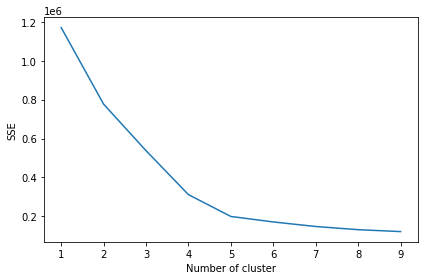

In [19]:
from sklearn.cluster import KMeans
sse = []
for i in range(1, 10):
    sse.append(KMeans(n_clusters=i, init='k-means++', random_state=10).fit(data_cluster).inertia_)
  
plt.plot(range(1,10), sse)
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Looks like the optimal number of cluster is somewhere between 5 and 7. Let’s pick 7 and check the cluster characteristics.

In [20]:
clusters = KMeans(n_clusters=7, init='k-means++', random_state=10).fit(data_cluster)
cluster_characteristics = pandas.DataFrame(clusters.cluster_centers_, columns = data_cluster.columns)

#### Add cluster size and label


In [21]:
cluster_characteristics['size']=np.bincount(clusters.labels_)
cluster_characteristics['label']= range(0, clusters.n_clusters)
print(cluster_characteristics)

   distance_from_home  time_delta_consecutive_transactions  distance_consecutive_transactions  transaction_dollar_amount    size  label
0           -0.111353                            -0.481830                          -0.156157                  -0.125421  216173      0
1            6.106475                            -0.026888                           4.264822                  -0.076666    2560      1
2           -0.111528                             2.441456                          -0.152872                  -0.121949   25446      2
3           -0.091324                            -0.002438                          -0.102263                   6.627694    5360      3
4           -0.119909                            -0.026522                           5.652444                  -0.095666    3822      4
5           -0.107932                             1.080113                          -0.151988                  -0.124353   38696      5
6           10.609471                           

It looks like some clusters are really extreme on at least one dimension. Let’s only pick the clusters with at least one dimension above 2 in absolute value. Since we scaled the data, this represents two standard deviations.

#### These are going to be anomaly clusters: at least one absolute value larger than 2.

In [22]:
anomaly_cluster = pandas.melt(cluster_characteristics,id_vars=['label', 'size'],var_name='variable', value_name='value')
anomaly_cluster = anomaly_cluster.query('abs(value)>2').sort_values("label")
print(anomaly_cluster)

    label   size                             variable      value
1       1   2560                   distance_from_home   6.106475
15      1   2560    distance_consecutive_transactions   4.264822
9       2  25446  time_delta_consecutive_transactions   2.441456
24      3   5360            transaction_dollar_amount   6.627694
18      4   3822    distance_consecutive_transactions   5.652444
6       6   1544                   distance_from_home  10.609471
20      6   1544    distance_consecutive_transactions   7.483565


We can see that cluster 3 has transactions with huge values. Cluster 4 is weird because consecutive transactions are very far from each other. Cluster 2 and 5 are weird because they have both transactions that are far from the user home as well as consecutive transactions are also far from each other, with cluster 5 being even more extreme than cluster 2.

Finally, cluster 0 has transactions that happen after a long time. This is probably not a reason to flag a transaction as suspicious. So we won’t include it. We would have included it if time_delta_consecutive_transactions had been highly negative, meaning tons of transactions right after each other, which is pretty common when a CC gets stolen.

#### Get rid of cluster 0 and check proportion of anomaly events

In [23]:
anomaly_cluster = anomaly_cluster.query('variable!=\"time_delta_consecutive_transactions\"')
print("Overall", round(anomaly_cluster['size'].unique().sum()/cluster_characteristics['size'].sum(), 3)*100, "percentage of events belong to anomaly clusters")

Overall 4.5 percentage of events belong to anomaly clusters


If we had chosen a more aggressive threshold than 2, we would have obviously got less anomalies and the other way round had we chosen a lower value. As usual, this would depend on the cost of false positives vs false negatives.

#### Finally, flag actual transactions

In [24]:
data_cluster['cluster'] = clusters.labels_
data_cluster['is_suspicious'] = data_cluster['cluster'].isin(anomaly_cluster['label'])
print(data_cluster[data_cluster['is_suspicious']].head())

     distance_from_home  time_delta_consecutive_transactions  distance_consecutive_transactions  transaction_dollar_amount  cluster  is_suspicious
93            -0.147015                            -0.418312                           3.432644                   0.130512        4           True
320            8.711714                            -0.580065                           6.115582                  -0.065607        6           True
331           -0.139284                            -0.647058                           6.113172                  -0.111455        4           True
458            7.957743                            -0.737842                           5.575102                  -0.657360        1           True
488           -0.135371                            -0.688045                          -0.195149                   5.267022        3           True


### Possible next steps/improvements

A problem we have with the current model is that, in order for an event to be classified as an anomaly, we need k-means to create a specific cluster. That will typically happen only if we have several events with similar characteristics.

A possible way to solve that could be looking into the distance from their cluster centroid for the transactions belonging to non-anomaly clusters. If they are particularly far (meaning they are an outlier within a non-anomaly cluster), we could label them as an anomaly as well.

Another problem stems from the fact that we defined anomalies as “far from the typical behaviour of that specific user”. As always when we go on a user level, this will only work as long as we have enough events per user.

A common way to solve this is to create a hybrid approach. If, for a given user, we have > X transactions, we look for anomalies based on that user pattern. If we have <= X transactions, we define anomalies as events that are far from the typical behaviour of similar users (or of all users in the extreme case that we have no way to define similar users).